In [2]:
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
datapath = os.path.join('..', 'data')
filterpath = os.path.join(datapath, 'filters', '8_19')
num_filters = 8

In [8]:
def visualise_joint(num_rows):
  _, axarr = plt.subplots(num_rows, 8, figsize=(10, num_rows))
  plt.axis('off')
  
  uuids = os.listdir(filterpath)
  for f in range(num_rows):
    file = np.random.choice(uuids, replace=True)
    filter = torch.load(os.path.join(filterpath, file))
    for i in range(8):
      if f < num_rows:
        axarr[f, i].set_axis_off()
        axarr[f, i].imshow(filter['0.weight'][i][0].detach().cpu(), norm=matplotlib.colors.Normalize(vmin=-2.5, vmax=2.5, clip=False), interpolation=None)

Visualising all filters (joint sampling)

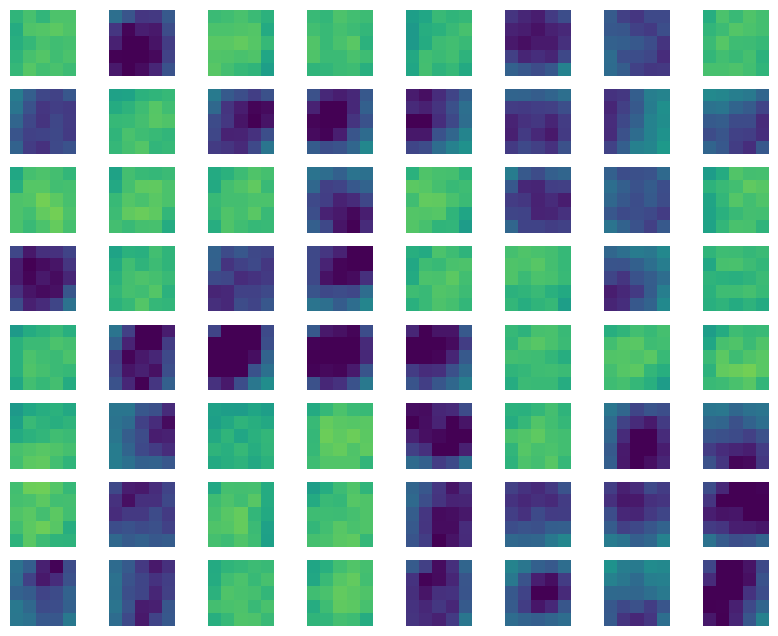

In [13]:
num_images = len(os.listdir(filterpath))
dataset = visualise_joint(8)

Visualising IID sampled filters

In [78]:
import matplotlib
def visualise_sampled_IID(num_rows):
    _, axarr = plt.subplots(num_rows, 8, figsize=(10, num_rows))
    plt.axis('off')

    uuids = os.listdir(filterpath)
    for f in range(num_rows):
        for i in range(8):
            file = np.random.choice(uuids, replace=True)
            filter = torch.load(os.path.join(filterpath, file))
            idx = np.random.choice(8)
            axarr[f, i].set_axis_off()
            axarr[f, i].imshow(filter['0.weight'][idx][0].detach().cpu(), norm=matplotlib.colors.Normalize(vmin=-1.5, vmax=1.5, clip=False), interpolation=None)

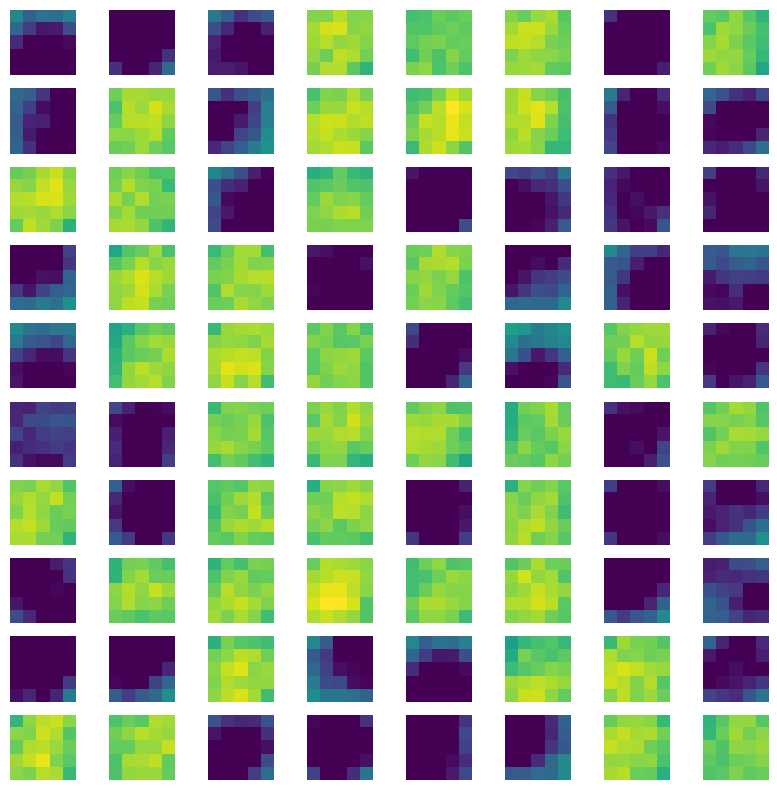

In [79]:
visualise_sampled_IID(10)

553


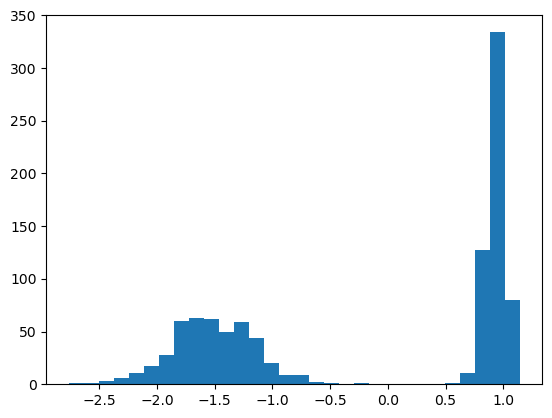

In [17]:
import matplotlib
def histogram_sampled_IID(num_samples):

    vals = []
    uuids = os.listdir(filterpath)
    num_over_0 = 0
    for f in range(num_samples):
        file = np.random.choice(uuids, replace=True)
        filter = torch.load(os.path.join(filterpath, file))
        idx = np.random.choice(8)
        vals.append(np.mean(filter['0.weight'][idx][0].detach().cpu().numpy()))
        if vals[-1] > 0:
            num_over_0 += 1
    plt.hist(vals, bins=30)
    print(num_over_0)


histogram_sampled_IID(1000)

NameError: name 'vals' is not defined

Visualising VAE sampled filters

In [17]:
import torch.nn as nn
x_dim  = 25
hidden_dim = 10
latent_dim = 5
vae_batch_size = 100
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [14]:
model.load_state_dict(torch.load('../data/vae_file.pt'))
model.eval()

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=25, out_features=10, bias=True)
    (FC_input2): Linear(in_features=10, out_features=10, bias=True)
    (FC_mean): Linear(in_features=10, out_features=5, bias=True)
    (FC_var): Linear(in_features=10, out_features=5, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=5, out_features=10, bias=True)
    (FC_hidden2): Linear(in_features=10, out_features=10, bias=True)
    (FC_output): Linear(in_features=10, out_features=25, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [18]:
with torch.no_grad():
    noise = torch.randn(vae_batch_size, latent_dim).to(device)
    generated_images =  model.Decoder(noise)
    # net[0].weight[c,:,:,:] = generated_filter[0].view(5, 5)


In [19]:
def show_image(x, idx):
    x = x.view(vae_batch_size, 5, 5)
    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

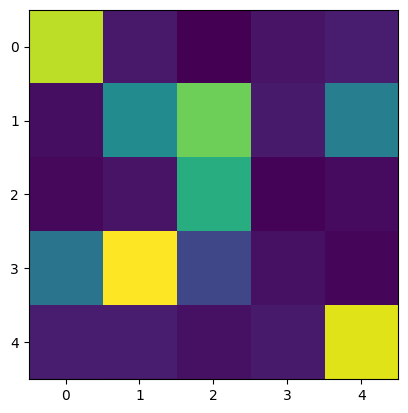

In [20]:
show_image(generated_images, idx=12)

In [22]:
def visualise_vae(num_rows, generated_images):
  _, axarr = plt.subplots(num_rows, 16, figsize=(10, num_rows))

  x = generated_images
  x = x.view(vae_batch_size, 5, 5)

  for i in range(num_rows):
    for j in range(16):
      axarr[i, j].set_axis_off()
      axarr[i, j].imshow(x[16*i+j].cpu().numpy(), interpolation=None)

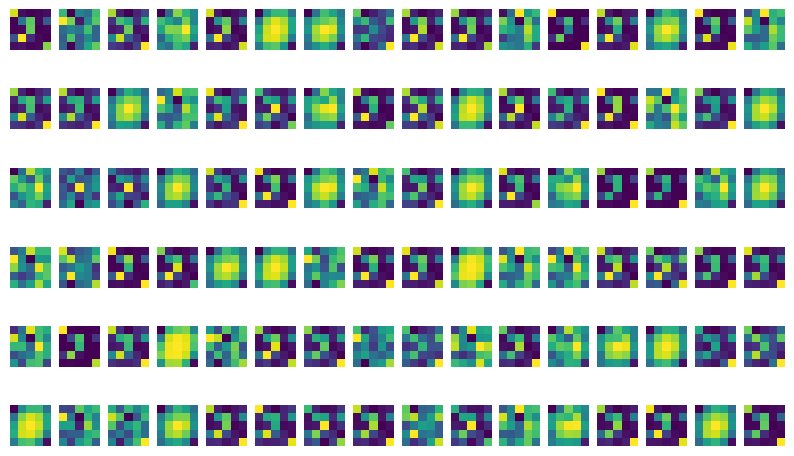

: 

In [23]:
visualise_vae(100//num_filters, generated_images)

In [116]:
import torch.nn as nn
import os
import matplotlib
device = torch.device('cpu')
nz=8
ngpu=1
netG_load = '../dcgan-out/netG_epoch_990.pth'
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nz, 64),
            nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 25),
            
            
            # EDITED


        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load(netG_load))



def visualise_dcgan(netG, num_rows, nz):
    _, axarr = plt.subplots(num_rows, 8, figsize=(10, num_rows))
    plt.axis('off')

    uuids = os.listdir(filterpath)
    for f in range(num_rows):
        noise = torch.randn(8, nz, 1, 1, device=device)
        fake = netG(noise)
        for i in range(8):
            axarr[f, i].set_axis_off()
            axarr[f, i].imshow(fake[i].detach().reshape(5,5), norm=matplotlib.colors.Normalize(vmin=-.3, vmax=.3, clip=False), interpolation=None)

def histogram_dcgan(num_samples):

    uuids = os.listdir(filterpath)
    vals = []
    for f in range(num_samples // 8):
        noise = torch.randn(8, nz, 1, 1, device=device)
        fake = netG(noise)
        for i in range(8):
            vals.append(np.mean(fake[i].detach().reshape(5,5).numpy()))
    plt.hist(vals, bins=30)


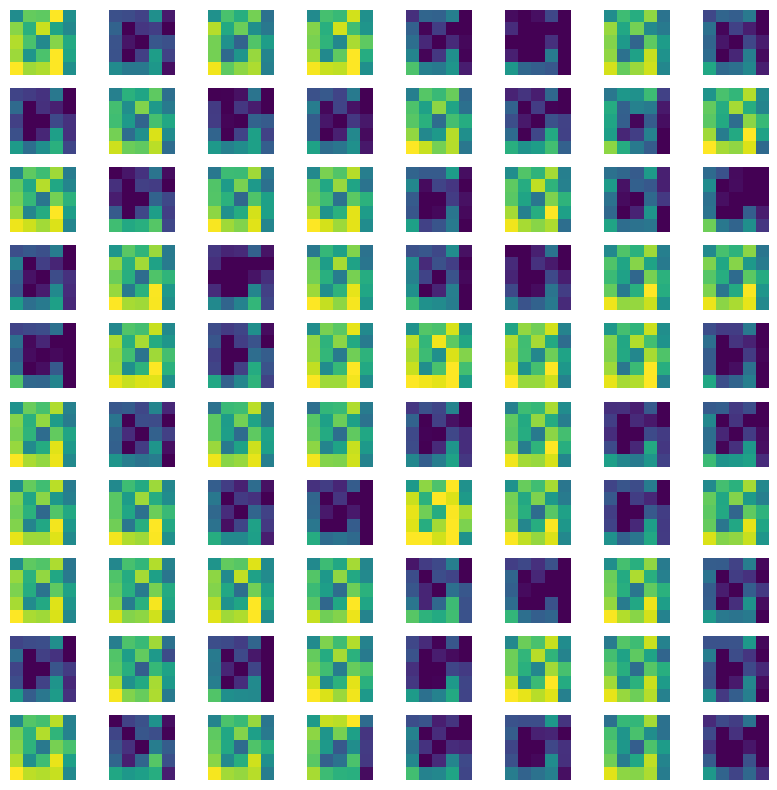

In [117]:

# histogram_dcgan(10000)
visualise_dcgan(netG, 10, nz)

In [4]:
import torch.nn as nn
import os
import matplotlib
device = torch.device('cpu')
nz=32
nc = 8
ngpu=1
netG_load = '../dcgan-out/netG_epoch_990.pth'
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nz, 64),
            nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 25 * 8),
            
            
            # EDITED


        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load(netG_load))



def visualise_dcgan_joint(netG, num_rows, nz):
    _, axarr = plt.subplots(num_rows, 8, figsize=(10, num_rows))
    plt.axis('off')

    uuids = os.listdir(filterpath)
    for f in range(num_rows):
        noise = torch.randn(2, nz, 1, 1, device=device)
        fake = netG(noise)
        for i in range(8):
            axarr[f, i].set_axis_off()
            axarr[f, i].imshow(fake[0,i*25:i*25 + 25].detach().reshape(5,5), norm=matplotlib.colors.Normalize(vmin=-.3, vmax=.3, clip=False), interpolation=None)

def histogram_dcgan_joint(num_samples):

    uuids = os.listdir(filterpath)
    vals = []
    for f in range(num_samples):
        noise = torch.randn(2, nz, device=device)
        fake = netG(noise)
        for i in range(8):
            vals.append(np.mean(fake[0,i*25:i*25 + 25].detach().reshape(5,5).numpy()))
    plt.hist(vals, bins=30)


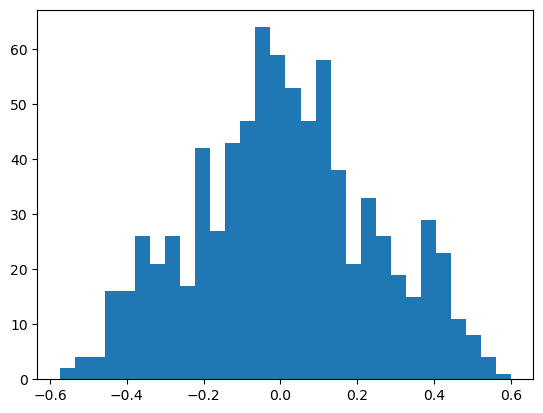

In [5]:
histogram_dcgan_joint(100)